In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [50]:
path_data = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\data\classification\credit_score.csv"
credit_data = pd.read_csv(path_data)

# Credit score classification 

https://www.kaggle.com/datasets/parisrohan/credit-score-classification

## Data cleaning

In [51]:
type_loan_clean = []
for text in list(credit_data["Type_of_Loan"].unique()):
    text = text.replace(","," ")
    text = text.replace("loan","")
    text = text.replace("not specified","")
    text = text.replace("No Data","")
    text = text.replace("  "," ")
    text = text.strip()
    
    type_loan_clean.append(text)

In [52]:
all_type_loan = " ".join(type_loan_clean)
types_loan = list(set([loan for loan in all_type_loan.split(" ") if loan !=""]))

In [53]:
for loan in types_loan:
    credit_data[f"{loan.capitalize()}Loan"] = credit_data["Type_of_Loan"].apply(lambda x: 1 if loan in x else 0)

In [54]:
# Clean data
credit_data.drop(columns=["SSN","Name","Month","ID","Type_of_Loan","Payment_Behaviour"], inplace=True)
credit_data = credit_data.loc[~credit_data["Occupation"].isin(["Media_Manager","Manager"])]
credit_data["Age"] = credit_data["Age"].astype(int)

In [55]:
# Group customer data for numerical variables (mean)
num_columns = list(credit_data.select_dtypes(include=[float]).columns)
credit_data_num = credit_data[["Customer_ID"] + num_columns].groupby("Customer_ID").median().reset_index().round()

In [56]:
# Group customer data for categorical variables (mode)
cat_columns = list(credit_data.select_dtypes(include=[int,object]).columns)
credit_data_cat = credit_data[cat_columns].groupby("Customer_ID").apply(lambda group: group.mode().iloc[0] if not group.mode().empty else pd.Series(index=group.columns))
credit_data_cat = credit_data_cat.drop(columns=["Customer_ID"]).reset_index()

In [57]:
# Merge numerical and categorical merged datasets
credit_data_clean = credit_data_cat.merge(credit_data_num, on="Customer_ID", how="inner") # merge cleaned data for numerical and categorical variables
#credit_data_clean = credit_data_clean.sample(5000, random_state=0) # select 2000 samples randomly
credit_data_clean.reset_index(drop=True, inplace=True)
credit_data_clean.drop(columns=["Customer_ID"], inplace=True)

In [58]:
#credit_data_clean = credit_data_clean.loc[credit_data_clean["Occupation"].isin(credit_data_clean["Occupation"].unique()[:10])]

In [59]:
credit_data_clean.head()

,Age,Occupation,Credit_Mix,Payment_of_Min_Amount,Credit_Score,MortgageLoan,PersonalLoan,ConsolidationLoan,EquityLoan,StudentLoan,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
0,38.0,Journalist,Standard,Yes,Poor,0.0,0.0,0.0,0.0,0.0,...,48.0,12.0,11.0,8.0,1942.0,33.0,186.0,27.0,45.0,317.0
1,37.0,Developer,Standard,Yes,Standard,0.0,0.0,0.0,0.0,0.0,...,26.0,11.0,14.0,10.0,1139.0,28.0,296.0,0.0,51.0,362.0
2,22.0,Accountant,Standard,Yes,Standard,0.0,0.0,0.0,0.0,1.0,...,19.0,18.0,17.0,7.0,982.0,36.0,334.0,188.0,101.0,567.0
3,44.0,Writer,Standard,Yes,Standard,0.0,1.0,0.0,0.0,0.0,...,20.0,14.0,15.0,6.0,1372.0,35.0,182.0,258.0,102.0,469.0
4,30.0,Mechanic,Good,No,Standard,1.0,1.0,0.0,1.0,0.0,...,9.0,2.0,3.0,1.0,1071.0,33.0,314.0,62.0,53.0,400.0


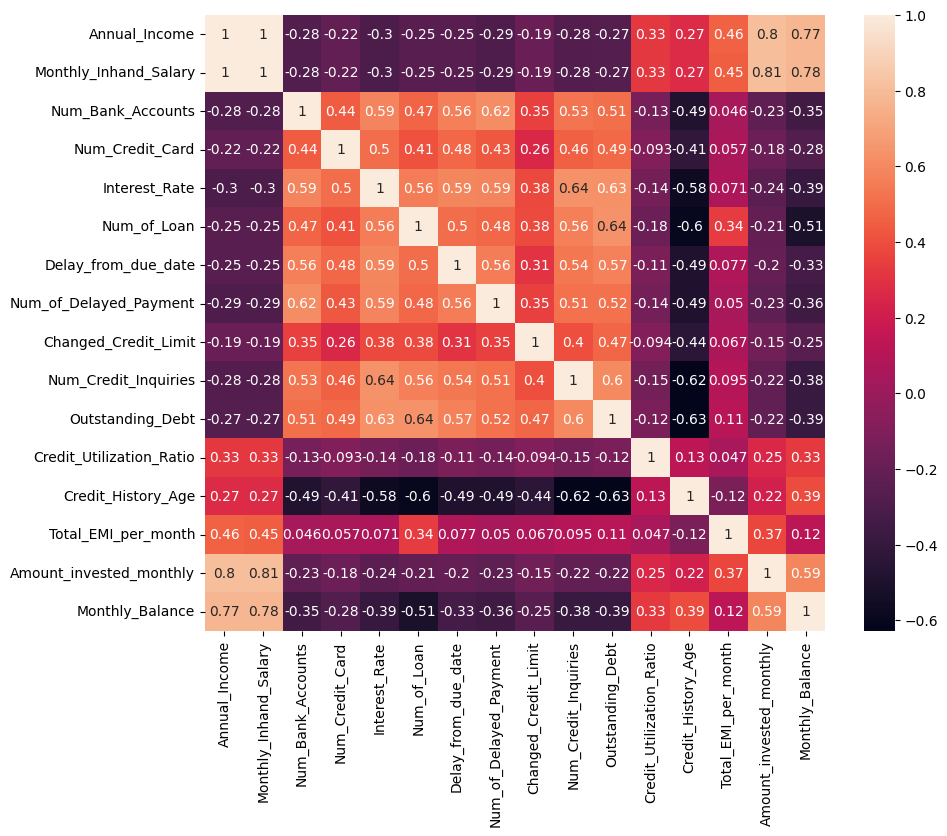

In [60]:
plt.figure(figsize=(10,8))
sns.heatmap(credit_data_clean[num_columns].corr(), annot=True)
plt.show()

In [61]:
drop_corr_columns = ["Monthly_Inhand_Salary","Amount_invested_monthly", "Num_Credit_Inquiries", 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Monthly_Balance']
credit_data_clean.drop(columns=drop_corr_columns, inplace=True)
num_columns_clean = [col for col in num_columns if col not in drop_corr_columns]

In [62]:
# Identify possible outliers
credit_data_clean[num_columns_clean].describe().round(2)

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age
count,10856.00,10856.00,10856.00,10856.00,10856.00,10856.00,10856.00,10856.0,10856.00,10856.0
mean,50425.14,5.38,5.54,14.53,3.54,21.06,13.31,10.4,1425.71,220.9
std,38312.18,2.60,2.06,8.76,2.44,14.74,6.20,6.5,1153.63,99.5
min,7006.00,0.00,0.00,1.00,0.00,0.00,0.00,0.0,0.00,4.0
25%,19294.00,3.00,4.00,7.00,2.00,10.00,9.00,5.0,563.00,144.0
50%,36930.50,6.00,5.00,13.00,3.00,18.00,14.00,9.0,1168.00,218.0
75%,71619.75,7.00,7.00,20.00,5.00,28.00,18.00,15.0,1950.00,300.5
max,179987.00,10.00,11.00,34.00,9.00,62.00,25.00,30.0,4998.00,400.0


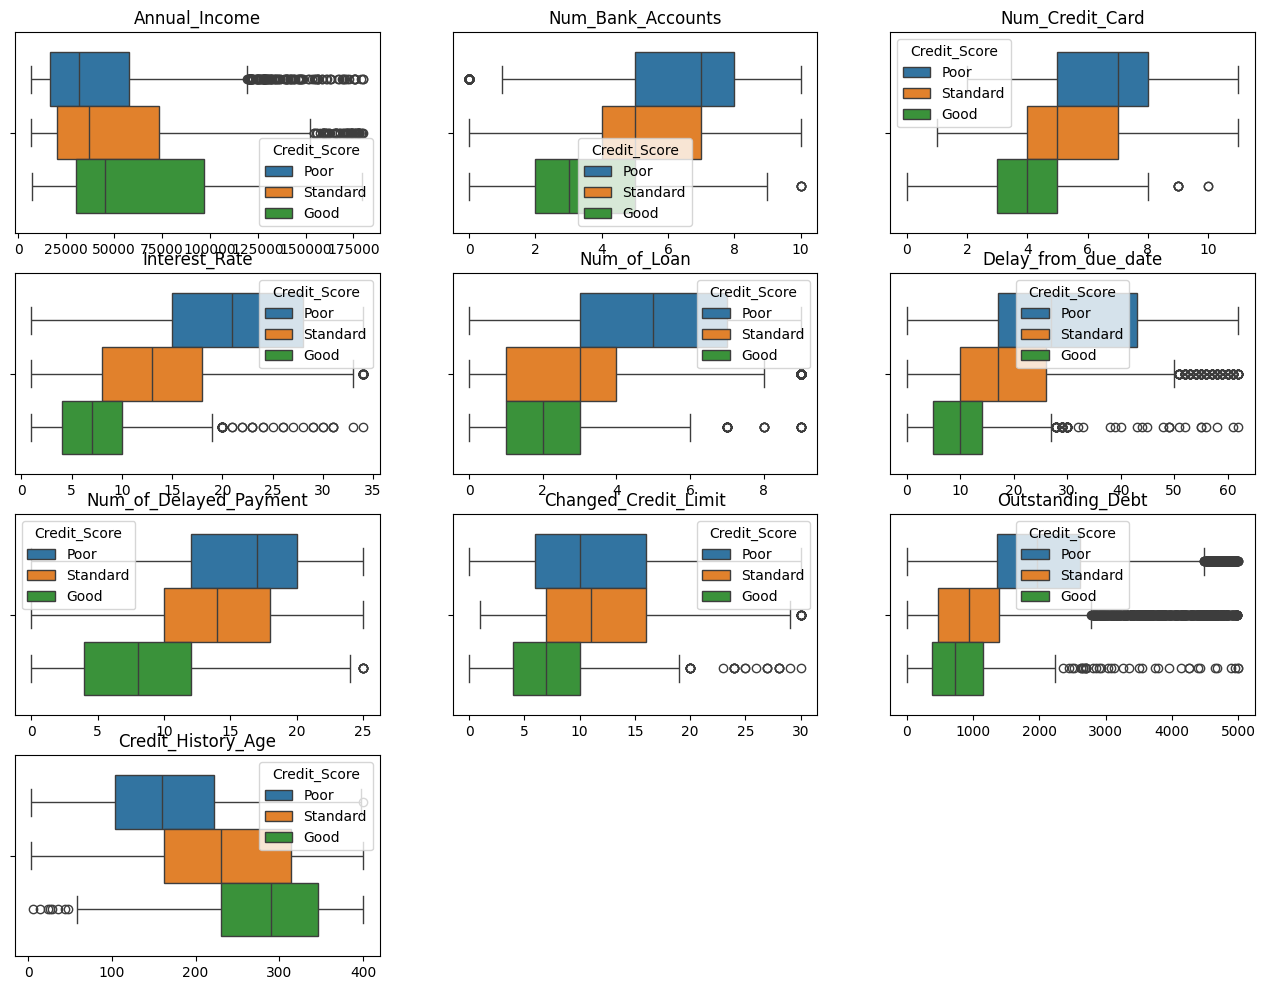

In [63]:
plt.figure(figsize=(16,12))
for i,col in enumerate(credit_data_clean[num_columns_clean].columns):
    plt.subplot(4,3,i+1)
    sns.boxplot(data=credit_data_clean, x=col, hue="Credit_Score", fill="Credit_Score")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(str(col))

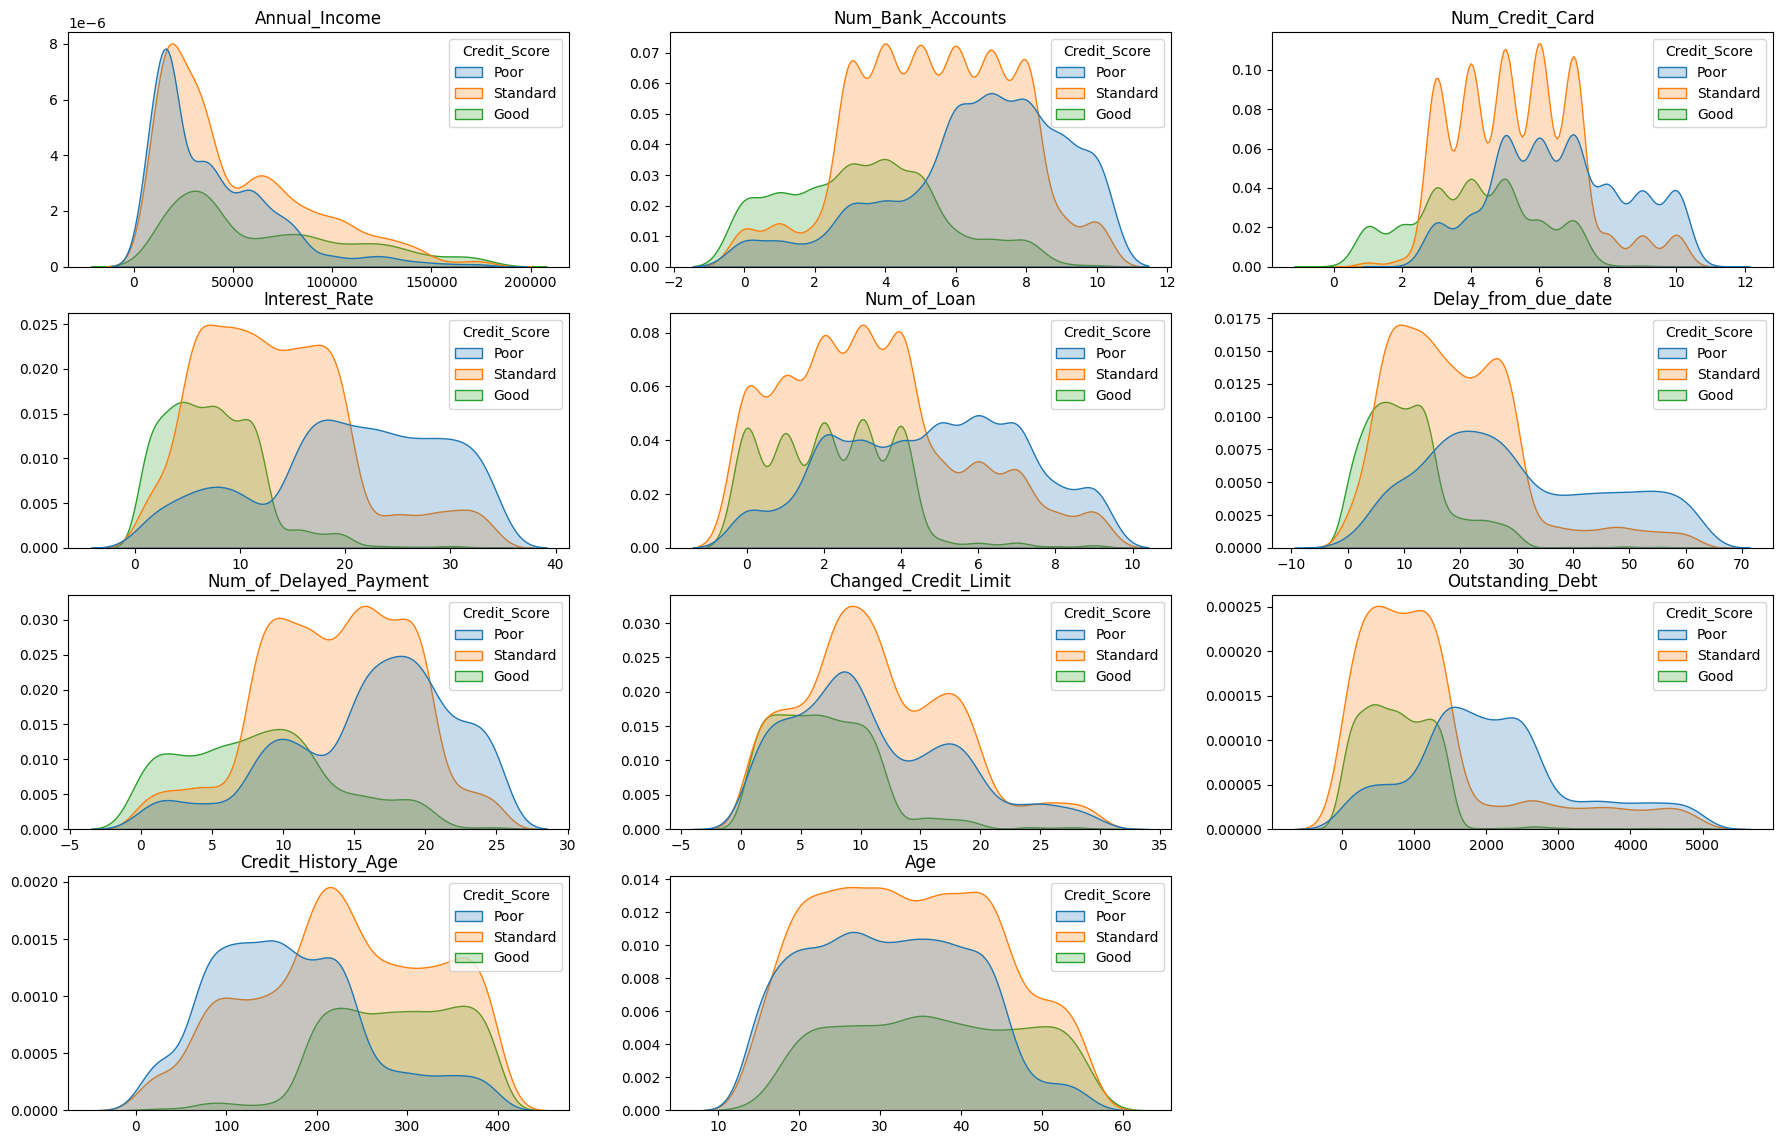

In [65]:
# Exploratory Data Analysis on numerical variables
plt.figure(figsize=(22,14))
for i,col in enumerate(list(credit_data_clean[num_columns_clean].columns) + ["Age"]):
    plt.subplot(4,3,i+1)
    sns.kdeplot(data=credit_data_clean, x=col, hue="Credit_Score", fill="Credit_Score")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(str(col))

<Axes: xlabel='Credit Mix', ylabel='value'>

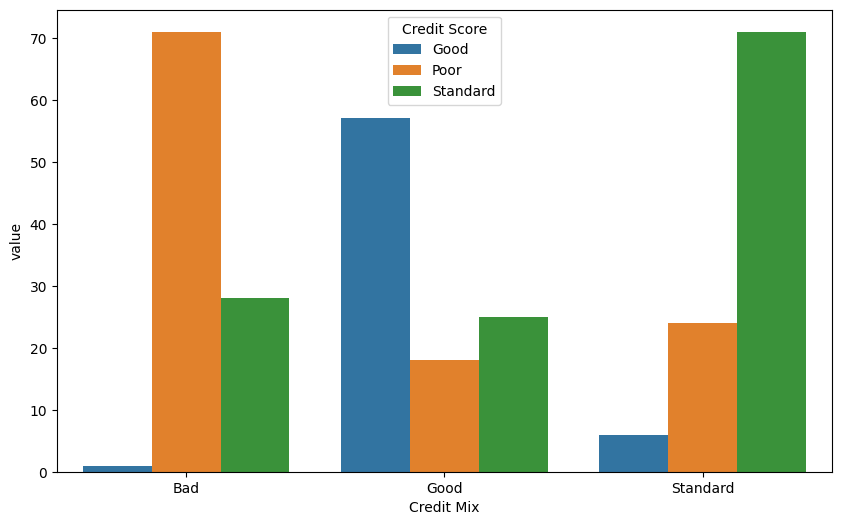

In [66]:
credit_occupation_df = pd.crosstab(credit_data_clean["Credit_Mix"], 
                                   credit_data_clean["Credit_Score"], normalize="index").apply(lambda x: np.round(100*x)).reset_index(drop=False)
credit_occupation_df.rename_axis(None, axis=1, inplace=True)
credit_occupation_df = credit_occupation_df.melt(id_vars=["Credit_Mix"])
credit_occupation_df.rename({"variable":"Credit Score", "Credit_Mix":"Credit Mix"}, axis=1, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data = credit_occupation_df, x="Credit Mix", y="value", hue="Credit Score")

In [67]:
credit_data_clean.drop(columns=[col for col in cat_columns if "Loan" in col], inplace=True)

In [68]:
credit_data_clean

,Age,Occupation,Credit_Mix,Payment_of_Min_Amount,Credit_Score,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age
0,38.0,Journalist,Standard,Yes,Poor,16756.0,9.0,6.0,22.0,2.0,48.0,12.0,11.0,1942.0,186.0
1,37.0,Developer,Standard,Yes,Standard,33540.0,6.0,3.0,17.0,0.0,26.0,11.0,14.0,1139.0,296.0
2,22.0,Accountant,Standard,Yes,Standard,80984.0,6.0,3.0,15.0,4.0,19.0,18.0,17.0,982.0,334.0
3,44.0,Writer,Standard,Yes,Standard,104143.0,3.0,5.0,5.0,3.0,20.0,14.0,15.0,1372.0,182.0
4,30.0,Mechanic,Good,No,Standard,30023.0,3.0,7.0,6.0,4.0,9.0,2.0,3.0,1071.0,314.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10851,28.0,Journalist,Good,No,Good,44986.0,2.0,6.0,5.0,3.0,7.0,11.0,11.0,1428.0,190.0
10852,20.0,Mechanic,Standard,Yes,Poor,19267.0,6.0,5.0,26.0,6.0,13.0,12.0,16.0,1732.0,160.0
10853,38.0,Lawyer,Standard,Yes,Poor,32126.0,7.0,9.0,23.0,3.0,11.0,16.0,8.0,2557.0,74.0
10854,23.0,Journalist,Standard,Yes,Standard,9608.0,7.0,4.0,10.0,6.0,8.0,11.0,10.0,1494.0,162.0


In [69]:
X = credit_data_clean.drop(columns=["Credit_Score"])
y = credit_data_clean["Credit_Score"]

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [71]:
# Save training data for app
X_train_save = X_train.copy()
X_train_save["Credit_Score"] = y_train

path_savedata = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\data\classification"
X_train_save.to_pickle(os.path.join(path_savedata,"credit_score_train.pkl"))

In [72]:
# Save test data for app
X_test_save = X_test.copy()
X_test_save.to_pickle(os.path.join(path_savedata,"credit_score_test.pkl"))

In [73]:
X_test

,Age,Occupation,Credit_Mix,Payment_of_Min_Amount,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age
9895,18.0,Architect,Bad,Yes,30353.0,8.0,8.0,23.0,7.0,45.0,23.0,3.0,2391.0,238.0
4101,45.0,Doctor,Good,No,18525.0,0.0,3.0,1.0,3.0,6.0,5.0,7.0,464.0,284.0
5730,52.0,Architect,Good,No,89496.0,1.0,4.0,9.0,2.0,0.0,1.0,7.0,1394.0,276.0
3156,43.0,Doctor,Standard,Yes,10389.0,3.0,6.0,24.0,6.0,5.0,18.0,10.0,1909.0,166.0
10595,44.0,Architect,Standard,Yes,57507.0,6.0,6.0,9.0,6.0,16.0,16.0,13.0,1278.0,224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2658,54.0,Lawyer,Good,No,14727.0,7.0,6.0,1.0,0.0,8.0,9.0,7.0,442.0,188.0
786,32.0,Teacher,Bad,Yes,9530.0,9.0,8.0,26.0,3.0,50.0,18.0,7.0,1818.0,82.0
9427,44.0,Lawyer,Bad,Yes,40667.0,8.0,6.0,34.0,5.0,45.0,20.0,18.0,4583.0,42.0
2397,33.0,Musician,Good,No,81411.0,5.0,5.0,6.0,1.0,13.0,4.0,5.0,468.0,344.0


In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

cat_columns_clean = [col for col in cat_columns if col not in ["Customer_ID","Credit_Score","Age"]]
cat_columns_clean = [col for col in cat_columns_clean if "Loan" not in col]
num_columns_clean.append("Age")

# Build data processing pipeline
ct = ColumnTransformer(
    [("numerical", RobustScaler(), num_columns_clean), 
     ("categorical", OneHotEncoder(sparse_output=False), cat_columns_clean)],
     remainder='passthrough')

X_train_pp = ct.fit_transform(X_train)
X_test_pp = ct.transform(X_test)

In [75]:
columns_transform = [col.split("__")[1] for col in ct.get_feature_names_out()]
df_clean = pd.DataFrame(X_train_pp, columns=columns_transform)
df_clean.head()

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age,...,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
0,1.638864,-0.75,-0.666667,-0.769231,-0.666667,-0.555556,-1.111111,-0.444444,-0.175705,0.784810,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.155810,-0.50,-0.333333,-0.076923,0.000000,0.000000,-0.666667,-0.222222,0.095445,0.569620,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.333935,0.75,0.000000,0.000000,0.333333,-0.500000,0.444444,0.555556,-0.801157,0.227848,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2.508556,0.00,0.333333,-0.384615,0.333333,-0.888889,-1.444444,-0.888889,-0.300795,0.848101,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.553243,1.00,1.666667,1.461538,1.666667,1.611111,0.888889,2.222222,1.284888,-0.607595,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [476]:
#import sklearn.linear_model.LogisticRegression

In [30]:
import lightgbm as lgb

params = {
'boosting_type': 'gbdt',
'num_leaves': 30,
'learning_rate': 0.05,
'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier()
clf.fit(X_train_pp, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 7599, number of used features: 40
[LightGBM] [Info] Start training from score -1.609306
[LightGBM] [Info] Start training from score -1.094279
[LightGBM] [Info] Start training from score -0.765303


LGBMClassifier()

In [31]:
from sklearn.metrics import accuracy_score

y_pred_lgb_train = clf.predict(X_train_pp)
print("Accuracy", accuracy_score(y_train, y_pred_lgb_train))

Accuracy 0.8988024740097381


In [32]:
y_pred_lgb_test = clf.predict(X_test_pp)
print("Accuracy", accuracy_score(y_test, y_pred_lgb_test))

Accuracy 0.7537611298741173


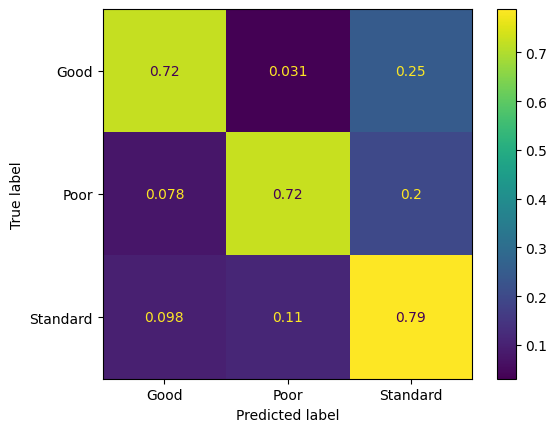

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_lgb_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

rf = RandomForestClassifier(max_depth=14, class_weight="balanced_subsample", n_estimators=600)
rf.fit(X_train_pp, y_train)

y_pred_rf_train = rf.predict(X_train_pp)
y_pred_rf_test = rf.predict(X_test_pp)

print("Train Accuracy", accuracy_score(y_train, y_pred_rf_train))
print("Test Accuracy", accuracy_score(y_test, y_pred_rf_test))

Train Accuracy 0.8840636925911304
Test Accuracy 0.7463923856309487


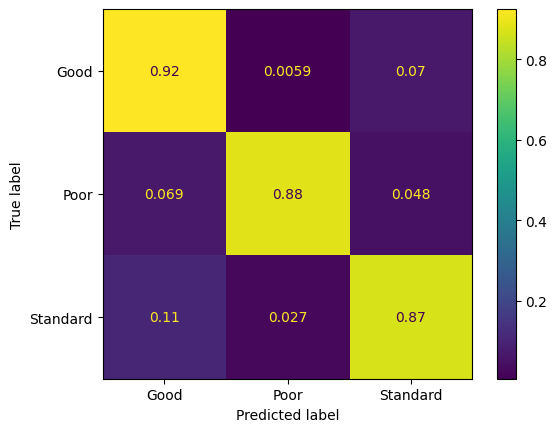

In [82]:
cm = confusion_matrix(y_train, y_pred_rf_train, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

In [83]:
import pickle

path_model = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\pretrained_models\supervised_learning"
with open(os.path.join(path_model,'credit_score_model.pkl'),'wb') as f:
    pickle.dump(rf,f)

### Explainability

In [442]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_pp)

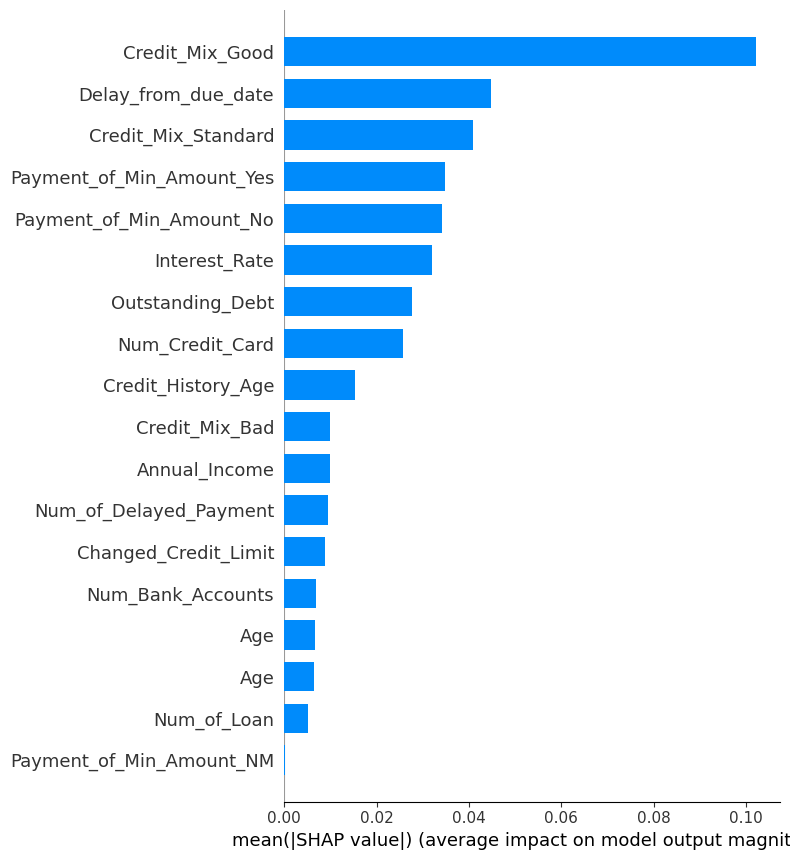

In [417]:
shap.summary_plot(shap_values[0], X_train_pp, feature_names=df_clean.columns, plot_type='bar')

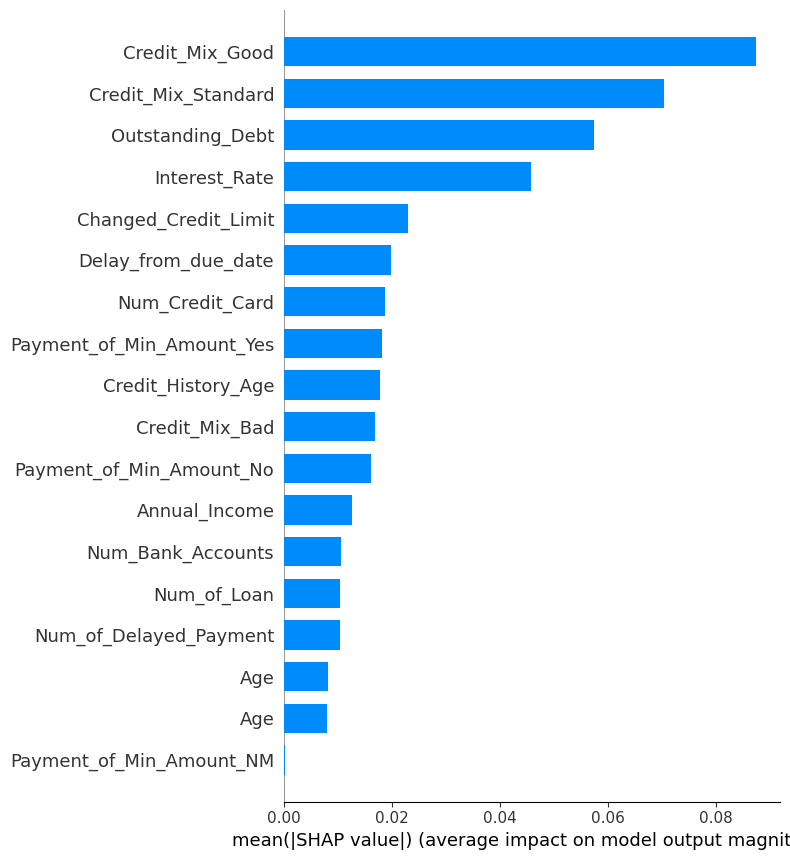

In [419]:
shap.summary_plot(shap_values[2], X_train_pp, feature_names=df_clean.columns, plot_type='bar')

18


<Axes: xlabel='importance', ylabel='variable'>

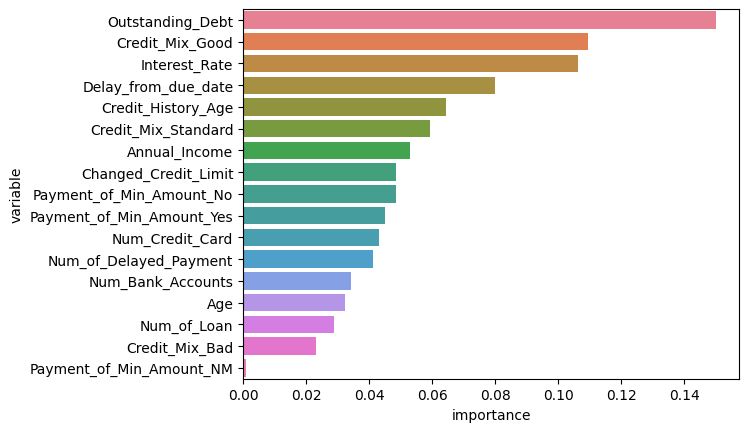

In [412]:
columns_transform = [col.split("__")[1] for col in ct.get_feature_names_out()]
print(len(columns_transform))

df_features_imp = pd.DataFrame({"variable":columns_transform,
                               "importance":rf.feature_importances_}).sort_values(by=["importance"], ascending=False)

sns.barplot(data=df_features_imp, x="importance", y="variable", hue="variable")

In [116]:
dict_grid = {'max_depth': np.arange(6,14,2),
             'max_features': ['log2', 'sqrt'],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400, 600, 800]}

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
rf_gridsearch = GridSearchCV(rf, dict_grid)
rf_gridsearch.fit(X_train_pp, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 6,  8, 10, 12]),
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800]})

In [21]:
rf_gridsearch.best_params_

{'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 200}

In [22]:
rf_gridsearch.best_score_

0.7299518572581304